In [1]:
# My usual setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas 
from datetime import datetime
import seaborn as sns
import glob
from os.path import basename
sns.set_context('poster') 
import numpy as np

# Sonify gun violence 2013-2017 
- Original tutorial https://github.com/cirlabs/miditime
- I handle most manipulations in dataframe for ease of IO

## First, format files

In [2]:
df = pandas.read_csv('../data/mass-shootings-2013-2017-CORNING.csv')

In [3]:
df.head()

,date,state,city_county,address,nkill,ninjured,operations
0,14-Nov-17,California,Corning,17357 Stagecoach Rd,5,10,NaN
1,12-Nov-17,Indiana,Gary,4601 Melton Rd,0,7,NaN
2,12-Nov-17,Georgia,Atlanta,50 Lower Alabama St,2,2,NaN
3,12-Nov-17,California,Fresno,S Calvin Ave,0,5,NaN
4,11-Nov-17,Texas,Dallas,2532 Martin Luther King Jr Blvd,1,3,NaN


In [4]:
df['datetime'] = pandas.to_datetime(df.date, infer_datetime_format=True)

In [5]:
df.head()

,date,state,city_county,address,nkill,ninjured,operations,datetime
0,14-Nov-17,California,Corning,17357 Stagecoach Rd,5,10,NaN,2017-11-14
1,12-Nov-17,Indiana,Gary,4601 Melton Rd,0,7,NaN,2017-11-12
2,12-Nov-17,Georgia,Atlanta,50 Lower Alabama St,2,2,NaN,2017-11-12
3,12-Nov-17,California,Fresno,S Calvin Ave,0,5,NaN,2017-11-12
4,11-Nov-17,Texas,Dallas,2532 Martin Luther King Jr Blvd,1,3,NaN,2017-11-11


In [6]:
df_nkill = df.groupby('datetime').nkill.sum().to_frame()

In [7]:
print(df_nkill.index.max())
print(df_nkill.index.min())

2017-11-14 00:00:00
2013-01-01 00:00:00


In [8]:
print(df_nkill.max())
print(df_nkill.min())

nkill    62
dtype: int64
nkill    0
dtype: int64


In [9]:
print(df_nkill.idxmax())

nkill   2017-10-01
dtype: datetime64[ns]


In [10]:
df_nkill.head()

,nkill
datetime,
2013-01-01,1
2013-01-07,4
2013-01-19,5
2013-01-21,0
2013-01-23,2


In [11]:
df_nkill.to_csv('../data/nkill-by-day-2013-2017.csv')

In [12]:
df_nkill['datetime'] = df_nkill.index

In [13]:
df_nkill.tail()

,nkill,datetime
datetime,,
2017-11-09,0,2017-11-09
2017-11-10,0,2017-11-10
2017-11-11,3,2017-11-11
2017-11-12,2,2017-11-12
2017-11-14,5,2017-11-14


### NEVER FORGET TO SORT

In [14]:
df_nkill.sort_index(inplace=True)

In [15]:
df_nkill.tail(10)

,nkill,datetime
datetime,,
2017-10-29,1,2017-10-29
2017-10-31,1,2017-10-31
2017-11-03,1,2017-11-03
2017-11-04,1,2017-11-04
2017-11-05,27,2017-11-05
2017-11-09,0,2017-11-09
2017-11-10,0,2017-11-10
2017-11-11,3,2017-11-11
2017-11-12,2,2017-11-12


## Chart data  

In [16]:
df_nkill.nkill.sum()

1792

In [17]:
df.ninjured.sum()

6607

In [18]:
df.ninjured.sum() + df.nkill.sum()

8399

In [19]:
df_nkill.nkill.max()

62

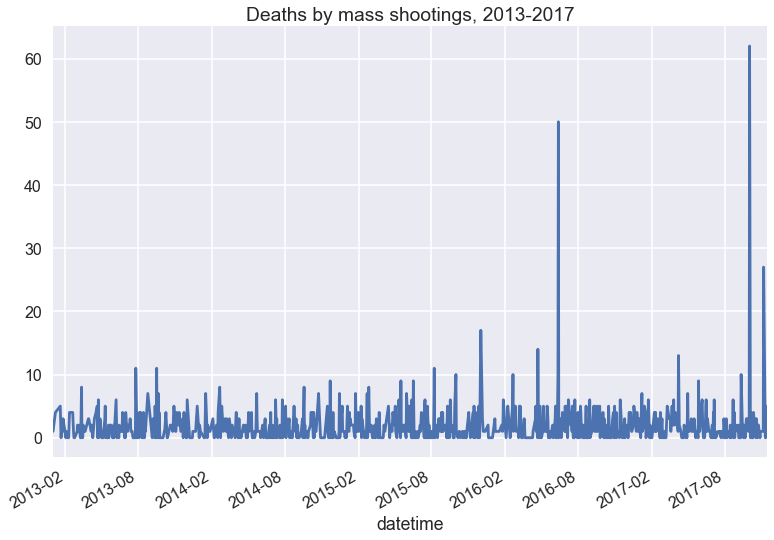

In [20]:

df_nkill.nkill.plot()

#plt.ylim([0, 70])
#plt.xlim(['2013-01-01','2017-11-20'])

plt.title('Deaths by mass shootings, 2013-2017')

In [21]:
df_nkill.nkill.to_csv('../data/nkill-by-day-2013-2017.csv')

## MIDITime initialization

Instantiate the class with a tempo (120bpm is the default), an output file destination, the number of seconds you want to represent a year in the final song (default is 5 sec/year), the base octave (C5 is middle C, so the default is 5, and how many octaves you want your output to range over (default is 1).

In [22]:
from miditime.miditime import MIDITime
BPM = 120
FILENAME = '../audio/2013-2017-nkill-100s.mid'
SEC_PER_YEAR = 20
BASE_OCTAVE = 5
OCTAVES = 1

mymidi = MIDITime(BPM,FILENAME, SEC_PER_YEAR, BASE_OCTAVE, OCTAVES)

Convert your date/time data into an integer, like days since the epoch (Jan. 1, 1970). You can use the days_since_epoch() helper method, or not:

In [23]:
df_nkill['epoched'] = df_nkill.datetime.apply(lambda x: mymidi.days_since_epoch(x))

## Our data is 5 years
Convert your integer date/time to something reasonable for a song. For example, at 120 beats per minute, you'll need to scale the data down a lot to avoid a very long song if your data spans years. This uses the seconds_per_year attribute you set at the top, so if your date is converted to something other than days you may need to do your own conversion. But if your dataset spans years and your dates are in days (with fractions is fine), use the beat() helper method.

In [24]:
df_nkill['beat'] = df_nkill['epoched'].apply(lambda x: mymidi.beat(x))

In [25]:
df_nkill.head()

,nkill,datetime,epoched,beat
datetime,,,,
2013-01-01,1,2013-01-01,15706.0,1720.03
2013-01-07,4,2013-01-07,15712.0,1720.68
2013-01-19,5,2013-01-19,15724.0,1722.00
2013-01-21,0,2013-01-21,15726.0,1722.22
2013-01-23,2,2013-01-23,15728.0,1722.44


In [26]:
START_TIME = df_nkill.beat.min() # beat doesn't start at 0 since we scaled our epoch seconds, so we just start at the first one.
print(START_TIME)

1720.03


In [27]:
df_nkill.head()

,nkill,datetime,epoched,beat
datetime,,,,
2013-01-01,1,2013-01-01,15706.0,1720.03
2013-01-07,4,2013-01-07,15712.0,1720.68
2013-01-19,5,2013-01-19,15724.0,1722.00
2013-01-21,0,2013-01-21,15726.0,1722.22
2013-01-23,2,2013-01-23,15728.0,1722.44


In [28]:
MAX = df_nkill.nkill.max()
MIN = df_nkill.nkill.min()
print(MIN,MAX)

0 62


## Create scale from nkill corresponding to volume

## We make deadlier days louder.

In [29]:
# KAT_MAX = 150   
# KAT_MIN = 25

In [30]:
MIN_V = 25
MAX_V = 150
#df['velocity'] = df.nkill.apply(lambda x: int(np.interp(x, [KAT_MIN, KAT_MAX], [25, 150])))
df_nkill['velocity'] = df_nkill.nkill.apply(lambda x: int(np.interp(x, [MIN, MAX], [25, 150])))

In [31]:
df_nkill.velocity.head(10)

datetime
2013-01-01    27
2013-01-07    33
2013-01-19    35
2013-01-21    25
2013-01-23    29
2013-01-25    27
2013-01-26    31
2013-02-02    25
2013-02-03    27
2013-02-07    25
Name: velocity, dtype: int64

## Build note list
- I know you're not supposed to iterate through a dataframe — but it's pretty small and manegable.
- [BEAT, PITCH, VELOCITY (VOLUME), DURATION_OF_NOTE]

In [32]:
scaled_data = df_nkill.to_dict('records')

In [33]:
note_list = []  
#V = 100 # constant for now
D = 1 # duration constant for now
P = 71 # constant pitch for now

for d in scaled_data:
    beat = d['beat'] - START_TIME
    pitch = P #d['pitch']
    velocity = d['velocity']
    duration = D
    note_list.append([beat, pitch, velocity, duration])


In [34]:
note_list

[[0.0, 71, 27, 1],
 [0.65000000000009095, 71, 33, 1],
 [1.9700000000000273, 71, 35, 1],
 [2.1900000000000546, 71, 25, 1],
 [2.4100000000000819, 71, 29, 1],
 [2.6300000000001091, 71, 27, 1],
 [2.7400000000000091, 71, 31, 1],
 [3.5, 71, 25, 1],
 [3.6100000000001273, 71, 27, 1],
 [4.0499999999999545, 71, 25, 1],
 [4.2699999999999818, 71, 25, 1],
 [4.4900000000000091, 71, 33, 1],
 [4.6000000000001364, 71, 33, 1],
 [5.3600000000001273, 71, 33, 1],
 [5.5799999999999272, 71, 27, 1],
 [5.6900000000000546, 71, 25, 1],
 [5.7999999999999545, 71, 25, 1],
 [5.9100000000000819, 71, 25, 1],
 [6.5699999999999363, 71, 27, 1],
 [6.6800000000000637, 71, 29, 1],
 [6.7899999999999636, 71, 27, 1],
 [6.9000000000000909, 71, 27, 1],
 [7.1200000000001182, 71, 29, 1],
 [7.4400000000000546, 71, 25, 1],
 [7.5499999999999545, 71, 25, 1],
 [7.7699999999999818, 71, 41, 1],
 [7.8800000000001091, 71, 25, 1],
 [8.1000000000001364, 71, 25, 1],
 [8.2100000000000364, 71, 29, 1],
 [8.6500000000000909, 71, 27, 1],
 [8.75999

## Make MIDI file

In [35]:
# Add a track with those notes
mymidi.add_track(note_list)

# Output the .mid file
mymidi.save_midi()

71 0.0 1 27
71 0.65 1 33
71 1.97 1 35
71 2.19 1 25
71 2.41 1 29
71 2.63 1 27
71 2.74 1 31
71 3.5 1 25
71 3.61 1 27
71 4.05 1 25
71 4.27 1 25
71 4.49 1 33
71 4.6 1 33
71 5.36 1 33
71 5.58 1 27
71 5.69 1 25
71 5.8 1 25
71 5.91 1 25
71 6.57 1 27
71 6.68 1 29
71 6.79 1 27
71 6.9 1 27
71 7.12 1 29
71 7.44 1 25
71 7.55 1 25
71 7.77 1 41
71 7.88 1 25
71 8.1 1 25
71 8.21 1 29
71 8.65 1 27
71 8.76 1 27
71 9.63 1 31
71 9.74 1 31
71 10.4 1 27
71 10.51 1 29
71 10.73 1 27
71 10.84 1 25
71 11.28 1 31
71 11.72 1 33
71 12.04 1 35
71 12.15 1 25
71 12.37 1 37
71 12.48 1 25
71 12.7 1 27
71 12.81 1 31
71 13.25 1 25
71 13.47 1 25
71 13.58 1 25
71 13.69 1 25
71 14.12 1 31
71 14.23 1 35
71 14.34 1 25
71 14.45 1 25
71 14.67 1 27
71 14.78 1 25
71 15.0 1 25
71 15.11 1 29
71 15.22 1 25
71 15.55 1 29
71 15.66 1 29
71 15.77 1 29
71 16.1 1 27
71 16.21 1 25
71 16.42 1 25
71 16.53 1 29
71 16.64 1 25
71 17.19 1 37
71 17.41 1 25
71 17.52 1 27
71 17.96 1 25
71 18.07 1 29
71 18.18 1 27
71 18.72 1 27
71 18.83 1 27
71 18.9